# Labolatorium 2

### Autorzy:
Patryk Klatka \
Wojciech Łoboda

## Import bibliotek oraz ich konfiguracja

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

# Matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

## Rekurencyjne odwracanie macierzy

Odwracanie macierzy jest kluczowym elementem w wielu obszarach matematyki i inżynierii, szczególnie w analizie danych, statystycznych i obliczeniach związanych z algorytmami. Przykładowo, jest pomocne przy rozwiązywaniu układów równań liniowych, przy transformacjach geometrycznych w grafice komputerowej i wielu innych. 

### Psuedokod

Badana macierz:
$$
\begin{bmatrix}
    B_{11} & B_{12}\\
    B_{21} & B_{22} 
\end{bmatrix}
= 
\begin{bmatrix}
    A_{11} & A_{12}\\
    A_{21} & A_{22} 
\end{bmatrix} ^ {-1}
$$

Kroki:

1. Zawołanie reukrencyjne dla macierzy $A_{11}^{-1} = inverse(A_{11})$ 
2. Obliczenie dopełnienia Schura $S_{22} = A_{22} - A_{21} * A_{11}^{-1} * A_{12}$
3. Zawołanie reukrencyjne dla macierzy $S_{22}^{-1} = inverse(S_{22})$ 
4. Obilczenie odpowiednio:
    - $B_{11} = A_{11}^{-1} + A_{11}^{-1} * A_{12} * S_{22}^{-1} * A_{21} * A_{11}^{-1}$
    - $B_{12} = -A_{11}^{-1} * A_{12} * S_{22}^{-1}$
    - $B_{21} = -S_{22}^{-1} * A_{21} * A_{11}^{-1}$
    - $B_{22} = S_{22}^{-1}$


Najważniejszymi fragmentami powyższego pseudokodu są obliczenia rekurencyjne: w szczególności obliczenie dopełnienia Schura. Pozwala nam to na obliczenie macierzy odwrotnej blokowo, nie cierpiąc bardzo na złożoności obliczeniowej, czego dowiemy się w następnym punkcie. 

### Analiza złożoności obliczeniowej

W celu obliczenia złożoności obliczeniowej algorytmu rekurencyjnego odwracania macierzy, należy rozwiązać następujące równanie rekurencyjne:

$$
T(n) = 2T(\frac{n}{2}) + 10*C + d
$$

gdzie $C$ to złożoność obliczeniowa algorytmu mnożenia macierzy, a $d$ to liczba pozostałych operacji o stałej złożoności, którą pominiemy.

Dla każdego kroku, wykonujemy 2 zawołania rekurencyjne funkcji `inverse` oraz wykonujemy 10 mnożeń o złożoności danego algorytmu mnożenia macierzy. Załóżmy, że korzystamy z algorytmu Strassena o złożoności $O(n^{\log_2 7})$.

Korzystając z twierdzenia o rekurencji uniwersalnej (znane również pod nazwą Master Theorem):

$$
T(n) = aT(\frac{n}{b}) + f(n)
$$

wnioskujemy, że $a = 2$, $b = 2$ oraz $f(n) = 10*(\frac{n}{2})^{2.81}$.

Ponieważ $f(n)$ jest wielomianowo większe niż $n^{log_b a}$, to złożoność obliczeniowa algorytmu rekurencyjnego odwracania macierzy wynosi $\Theta(f(n)) = \Theta(n^{\log_2 7})$, a zatem wnioskujemy, że złożoność rekruencyjnego odwracania macierzy zależy od złożoności algorytmu mnożenia macierzy (wytłumaczenie wzorów [tutaj](https://brilliant.org/wiki/master-theorem/)).

In [2]:
def number_of_flops_in_matrix_multiplication(n):
    """
    Compute the number of flops in a matrix multiplication.

    Note that this is not the most efficient way to compute the product.
    It's just an approximation of the number of flops.
    """
    return 2 * n ** 3 - n ** 2

def inverse(A, l=0):
    """
    Inverse of a matrix using recursion.
    """
    # Get the shape of the matrix
    m, n = A.shape
    
    # Check if the matrix is square
    if m != n:
        raise ValueError('Matrix must be square.')
    
    # Check if the matrix is invertible
    if np.linalg.det(A) == 0:
        raise ValueError('Matrix is not invertible.')
    
    # Check if the matrix is 2x2
    if m == 2:
        # Compute the inverse of the matrix
        A_inv = np.zeros_like(A)
        A_inv[0, 0] = A[1, 1]
        A_inv[0, 1] = -A[0, 1]
        A_inv[1, 0] = -A[1, 0]
        A_inv[1, 1] = A[0, 0]
        A_inv /= np.linalg.det(A)
        
        return A_inv, 4
    
    # Otherwise, recursively compute the inverse
    else:
        # Split the matrix into blocks
        A11 = A[:m//2, :m//2]
        A12 = A[:m//2, m//2:]
        A21 = A[m//2:, :m//2]
        A22 = A[m//2:, m//2:]
        
        # Recursively compute the inverse of the block A11
        A11_inv, c1 = inverse(A11)
        
        # Compute the Schur complement
        S22 = A22 - A21 @ A11_inv @ A12

        # Compute the inverse of the Schur complement
        S22_inv, c2 = inverse(S22)

        # Compute the inverse of the matrix
        A_inv = np.zeros_like(A)
        A_inv[:m//2, :m//2] = A11_inv + A11_inv @ A12 @ S22_inv @ A21 @ A11_inv
        A_inv[:m//2, m//2:] = -A11_inv @ A12 @ S22_inv
        A_inv[m//2:, :m//2] = -S22_inv @ A21 @ A11_inv
        A_inv[m//2:, m//2:] = S22_inv

        return A_inv, l + c1 + c2 + number_of_flops_in_matrix_multiplication(n/2) * 10 + n

### Test poprawności algorytmu

In [3]:
test_matrix = np.array([
    [5,1,3,4],
    [0,1,8,5],
    [9,3,6,1],
    [7,3,9,2]
]).astype(np.float64)

m1 = inverse(test_matrix)
m2 = np.linalg.inv(test_matrix)
print("Correct" if np.allclose(m1[0], m2) else "ERROR")
print("Correct" if np.allclose(test_matrix, inverse(inverse(test_matrix)[0])[0]) else "ERROR")

Correct
Correct


### Analiza algorytmu

In [4]:
# Generate matrices
def generate_matrix(n):
    return np.random.uniform(0.00000001, 1, (n, n))

k = 12
test_matrices = [generate_matrix(2**i) for i in range(2, k+1)]

#### Czas wykonywania algorytmu

c:\Users\lobod\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


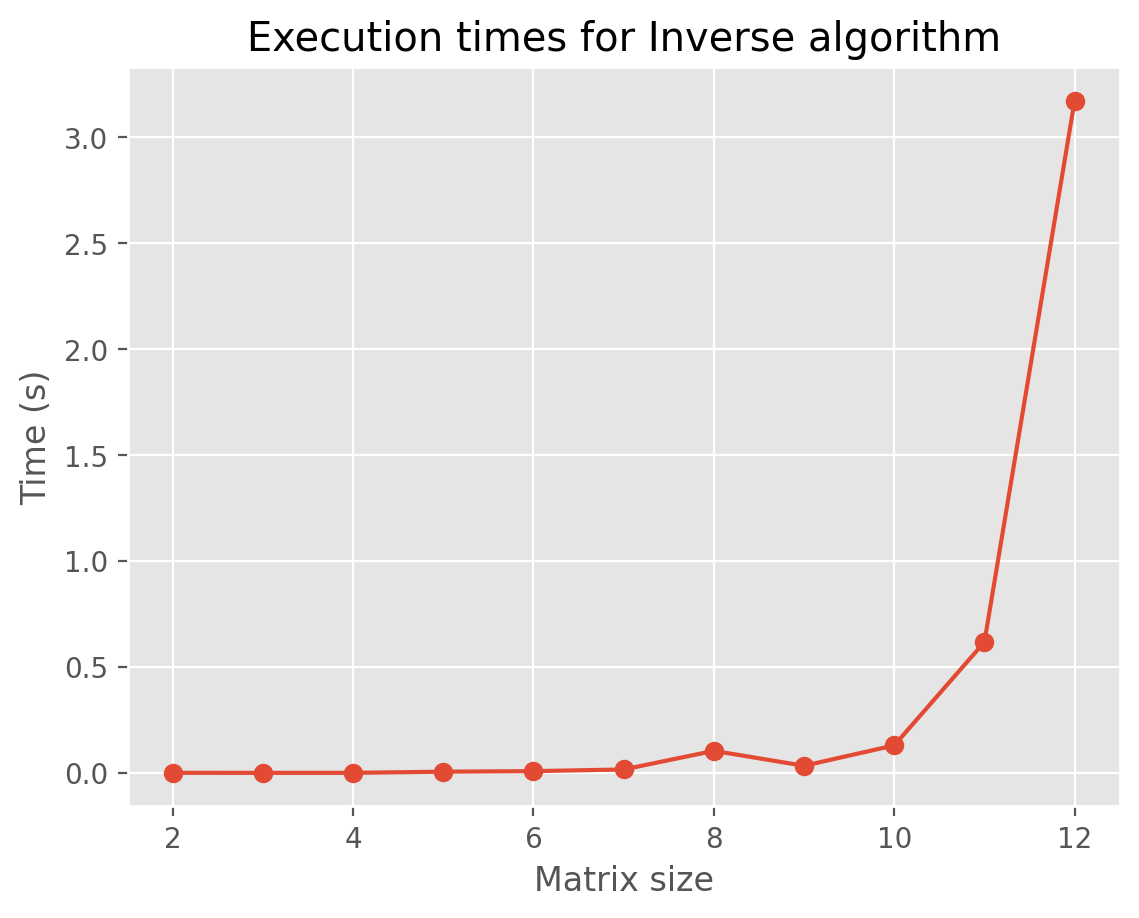

In [5]:
def plot_execution_times(algorithm, test_matrices):
    execution_times = []
    for A in test_matrices:
        start_time = time.time()
        algorithm(A)
        end_time = time.time()
        execution_times.append(end_time - start_time)

    plt.title("Execution times for " + algorithm.__name__.title() + " algorithm")
    plt.xlabel("Matrix size")
    plt.ylabel("Time (s)")
    plt.plot([i for i in range(2,k+1)] ,execution_times, 'o-')
    plt.show()

plot_execution_times(inverse, test_matrices)

#### Liczba operacji zmiennoprzecinkowych

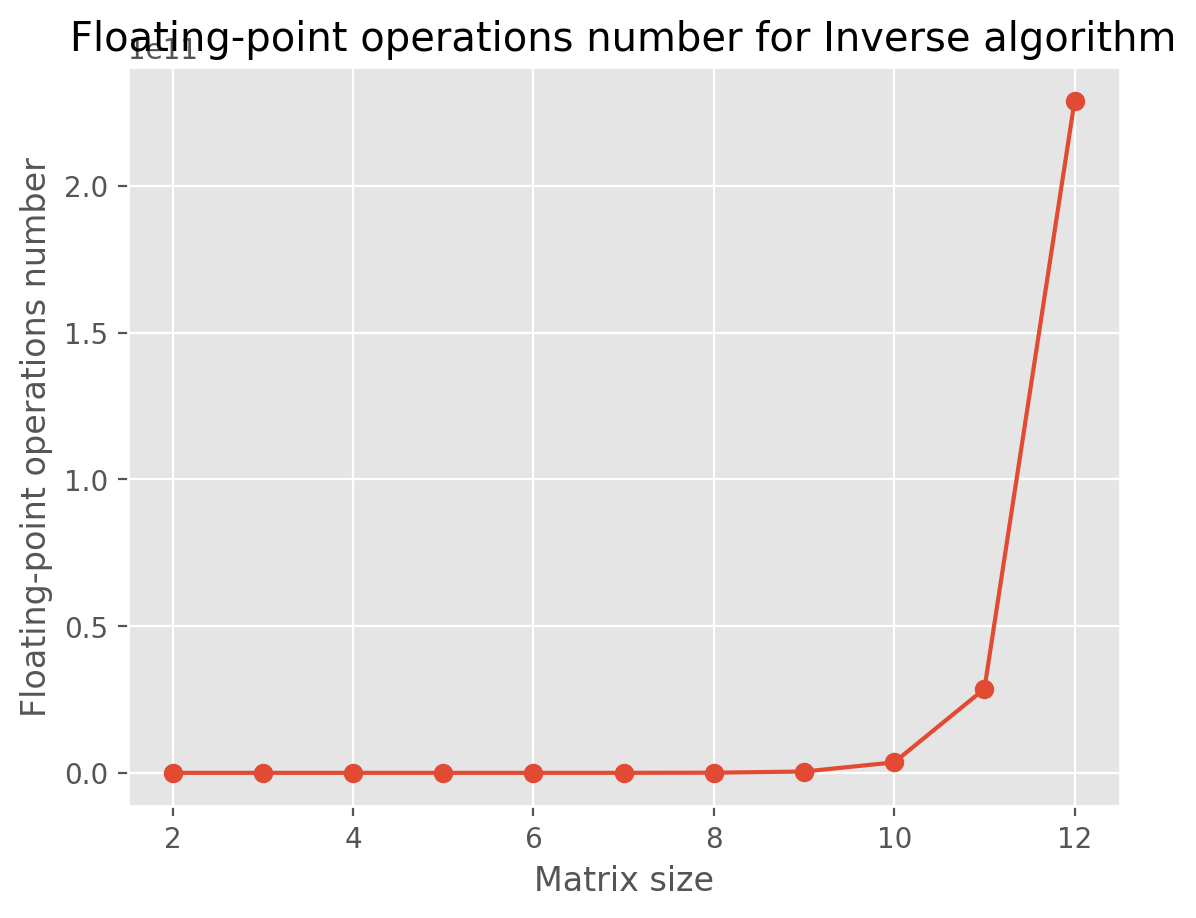

In [6]:
def plot_flops(algorithm, test_matrices):
    flops = []
    for A in test_matrices:
        res = algorithm(A)
        flops.append(res[-1])
    plt.title("Floating-point operations number for " + algorithm.__name__.title() + " algorithm")
    plt.xlabel("Matrix size")
    plt.ylabel("Floating-point operations number")
    plt.plot([i for i in range(2,k+1)] ,flops, 'o-')
    plt.show()

plot_flops(inverse, test_matrices)

## Rekurencyjna faktoryzacja LU

Faktoryzacja LU to metoda rozkładu macierzy na dwie macierze - L i U. Macierz L jest macierzą dolnotrójkątną, a U górną. Ta technika ma wiele zastosowań, wśród których najważniejsze to rozwiązywanie układów równań liniowych, obliczanie wyznacznika macierzy oraz odwracanie macierzy.

### Psuedokod

$$
LU = 
\begin{bmatrix}
    L_{11} & 0 \\
    L_{21} & L_{22} 
\end{bmatrix}
\begin{bmatrix}
    U_{11} & U_{12}\\
    0 & U_{22} 
\end{bmatrix} 
$$

Kroki do obliczenia rekurencyjnie podmacierzy $L$ oraz $U$:

1. Wyznaczenie macierzy $L_{11}$ oraz $U_{11}$ poprzez wykonanie rekurencyjne faktoryzacji LU dla macierzy $A_{11}$
2. Obliczenie rekurencyjnie $U_{11}^{-1} = inverse(U_{11})$
3. Obliczenie $L_{21} = A_{21} * U_{11}^{-1}$
4. Obliczenie rekurencyjne $L_{11}^{-1} = inverse(L_{11})$
5. Obliczenie $U_{12} = L_{11}^{-1} * A_{12}$
6. Obliczenie dopelnienia Schura $S = A_{22} - A_{21} * U_{11}^{-1} * L_{11}^{-1} * A_{12}$
7. Obliczenie rekurencyjne macierzy $L_s$ oraz $U_s$ dla macierzy $S$
8. Podstawienie $L_{22} = L_s$ oraz $U_{22} = U_s$


Najważniejszymi fragmentami powyższego pseudokodu są obliczenia rekurencyjne: w szczególności obliczenie dopełnienia Schura. Głównie te fragmenty pozwalają nam na wykonanie faktoryzacji LU macierzy blokowo.

### Analiza złożoności obliczeniowej

W celu obliczenia złożoności obliczeniowej algorytmu rekurencyjnego odwracania macierzy, należy rozwiązać następujące równanie rekurencyjne:

$$
T(n) = 4T(\frac{n}{2}) + 5*C + d
$$

gdzie $C$ to złożoność obliczeniowa algorytmu mnożenia macierzy, a $d$ to liczba pozostałych operacji o stałej złożoności, którą pominiemy.

Tak jak dla poprzedniego algorytmu, z twierdzenia o rekurencji uniwersalnej wnioskujemy, że $a = 4$, $b = 2$ oraz $f(n) = 5*(\frac{n}{2})^{2.81}$.

Ponieważ $f(n)$ jest wielomianowo większe niż $n^{log_b a}$, to złożoność obliczeniowa algorytmu rekurencyjnego odwracania macierzy wynosi $\Theta(f(n)) = \Theta(n^{\log_2 7})$, a zatem wnioskujemy, że złożoność rekruencyjnego odwracania macierzy zależy od złożoności algorytmu mnożenia macierzy.

In [7]:
def LU_factorization_recursive(A, l=0):
    """
    LU factorization of a matrix using recursion.
    """
    # Get the shape of the matrix
    m, n = A.shape
    
    # Check if the matrix is square
    if m != n:
        raise ValueError('Matrix must be square.')
    
    # Check if the matrix is 2x2
    if m == 2:
        # Compute the LU decomposition of the matrix
        L = np.eye(2)
        L[1, 0] = A[1, 0] / A[0, 0]

        U = np.zeros_like(A)
        U[0, 0] = A[0, 0]
        U[0, 1] = A[0, 1]
        U[1, 1] = A[1, 1] - L[1, 0] * A[0, 1]

        return L, U, 3
    else:
        # Split the matrix into blocks
        A11 = A[:m//2, :m//2]
        A12 = A[:m//2, m//2:]
        A21 = A[m//2:, :m//2]
        A22 = A[m//2:, m//2:]
        
        # Recursively compute the LU decomposition of the block A11
        L11, U11, c1 = LU_factorization_recursive(A11)

        U11_inv, c2 = inverse(U11)

        L21 = A21 @ U11_inv

        L11_inv, c3 = inverse(L11)

        U12 = L11_inv @ A12

        S = A22 - A21 @ U11_inv @ L11_inv @ A12

        Ls, Us, c4 = LU_factorization_recursive(S)

        U22 = Us
        L22 = Ls

        # Compute the LU decomposition of the matrix
        L = np.zeros_like(A)
        L[:m//2, :m//2] = L11
        L[m//2:, :m//2] = L21
        L[m//2:, m//2:] = L22

        U = np.zeros_like(A)
        U[:m//2, :m//2] = U11
        U[:m//2, m//2:] = U12
        U[m//2:, m//2:] = U22
        
        return L, U, l + c1 + c2 + c3 + c4 + number_of_flops_in_matrix_multiplication(n/2) * 5 + n

### Test poprawności algorytmu

In [8]:
test_matrix = np.array([
 [5, 2, 3 ,9],
 [2 ,4 ,6 ,8],
 [7, 4, 8 ,4],
 [3 ,4, 5, 5],

]).astype(np.float64)

m1 = LU_factorization_recursive(test_matrix)
print("Correct" if np.allclose(m1[0] @ m1[1], test_matrix) else "ERROR")

Correct


### Analiza algorytmu

#### Czas wykonywania algorytmu

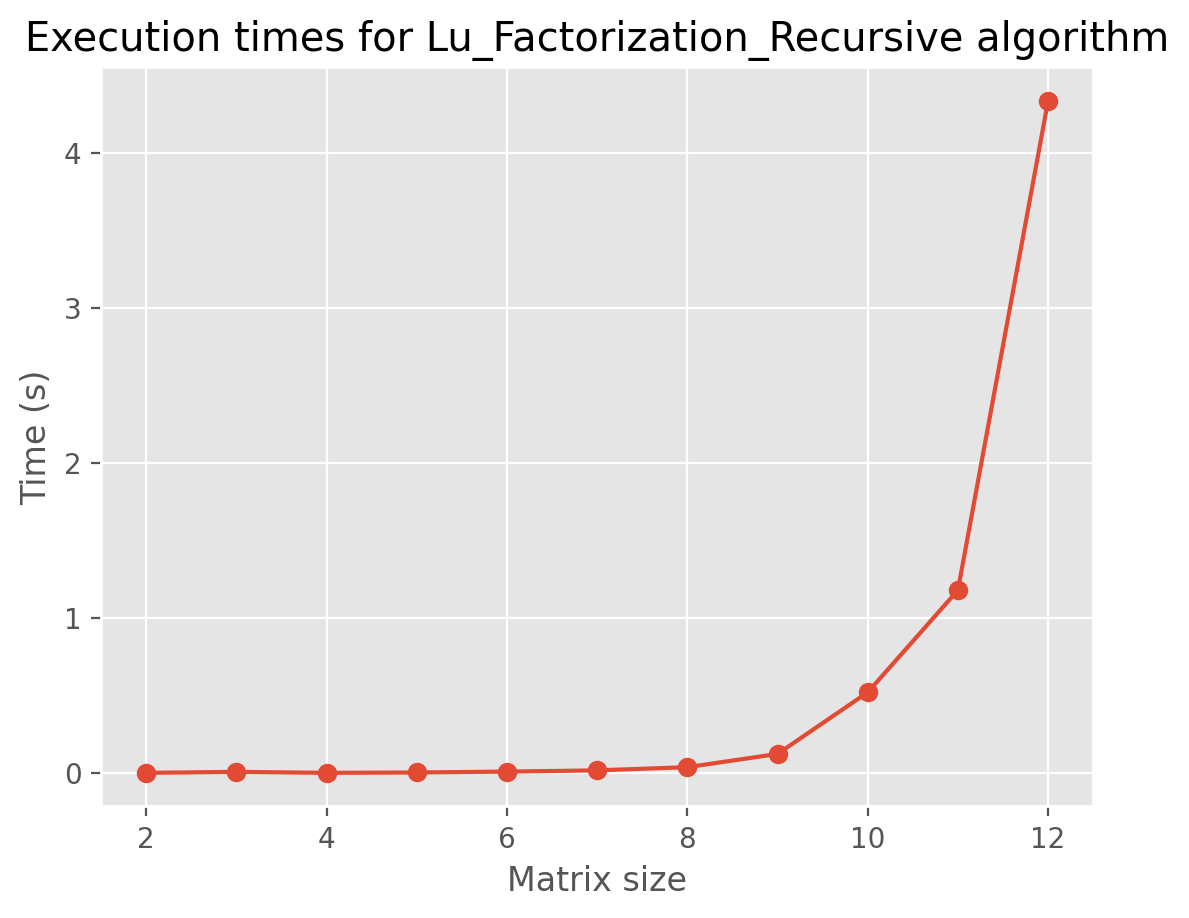

In [9]:
plot_execution_times(LU_factorization_recursive, test_matrices)

#### Liczba operacji zmiennoprzecinkowych

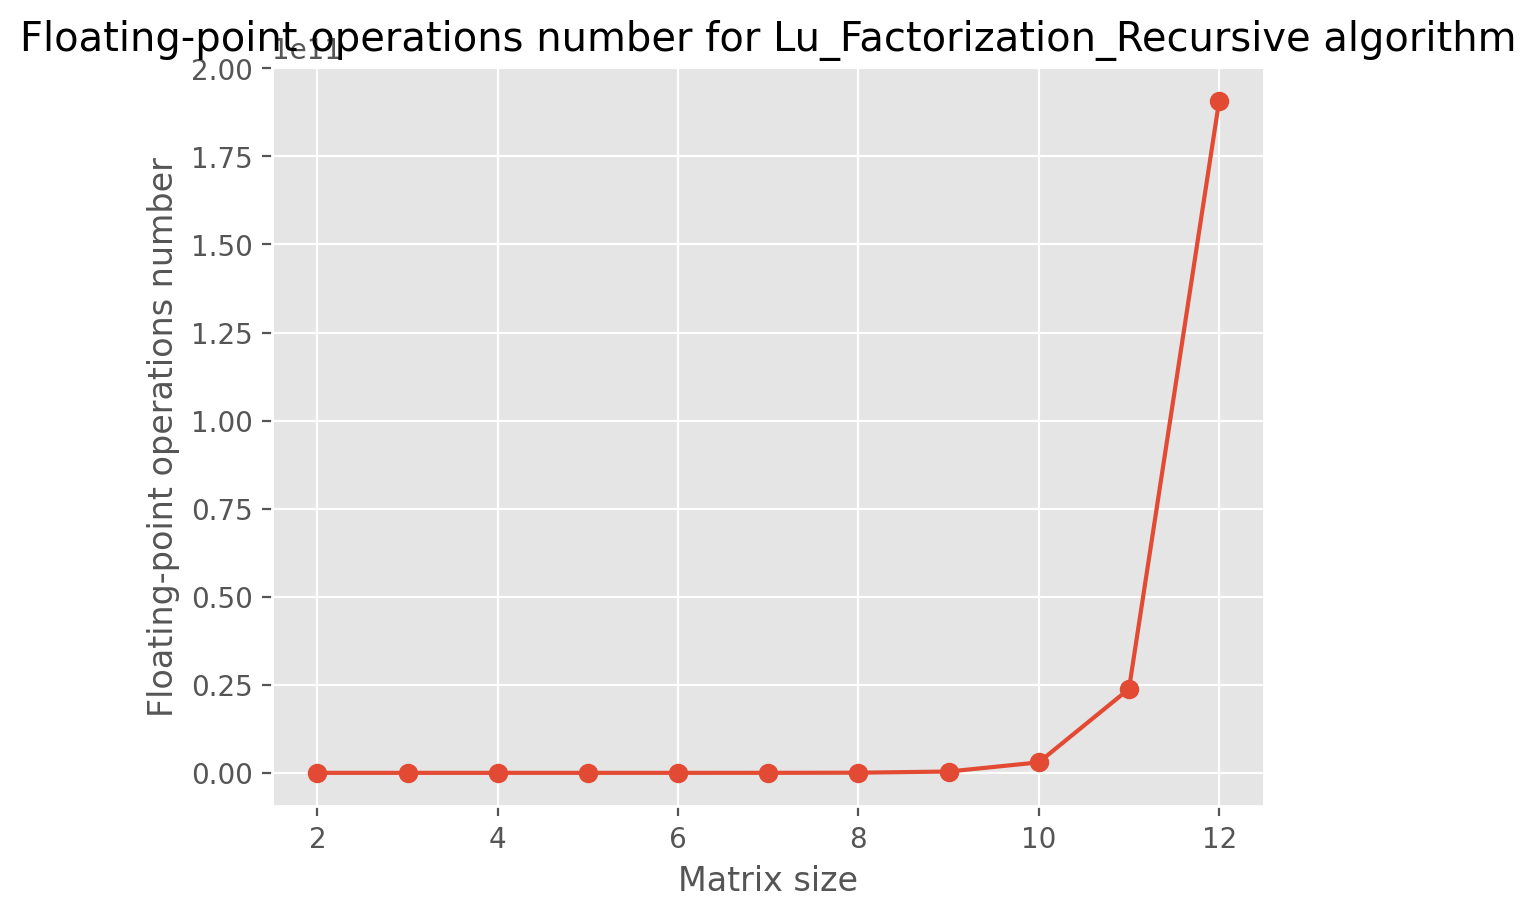

In [10]:
plot_flops(LU_factorization_recursive, test_matrices)

## Rekurencyjne obliczanie wyznacznika

Obliczanie wyznacznika to jedna z podstawowych operacji macierzowych. Wyznacznik to pewna wartość która charakteryzuje macierz kwadratową np. wyznacznik jest niezerowy wtedy i tylko wtedy kiedy macierz jest odwracalna. Wyznacznik może być wykorzystany między innymi do obliczania układów równań liniowych. 

Wzór na wyznacznik macierzy $A$ o rozmiarze $n \times n$:

$det(A) = \sum_{\sigma \in S_n} sgn(\sigma) \prod_{i = 1}^{n} a_{\sigma(i), i}$

gdzie $S_n$ to grupa permutacji n-elementowych, sgn to funkcja znaku permutacji, $a_{i, j}$ to element w i-tym wierszu i j-tej kolumnie.

Wykorzystując twierdzenie Cauchy'ego: $det(AB) = det(A) * det(B)$ oraz własność wyznacznika mówiącą że wyznacznik macierzy dolnejtrójkątnej i górnejtrójkątnej to iloczyn elementów znajdujących się na przekątnej macierzy, możemy wyprowadzić wzór na wyznacznik znając faktoryzacje LU macierzy: 

$det(A) = l_{11} * ... * l_{nn} * u_{11} * ... * u_{nn} = u_{11} * ... * u_{nn}$ (jeżeli zakładamy faktoryzacje z $l_{ii} = 1$)

gdzie $l_{ii}$ to elementu na przekątnej L i $u_{ii}$ to elementy na przekątnej U.

Pseudokod algorytmu obliczenia wyznacznika dla macierzy A:
1. Wyznaczenie rekurencyjnie faktoryzacji LU dla macierzy A.
2. Wymnożenie elementów na przekątnych macierzy L i U.



### Analiza złożoności obliczeniowej

Algorytm rekurencyjnego obliczenia wyznacznika macierzy $A$ o rozmiarze $n \times n$ polega na znalezieniu rekurencyjnie faktoryzaji LU co ma złożóność $O(n^{log_27})$ a następnie na wykonaniu $O(n)$ mnożeń elementów na przekątnych. A zatem złożóność całego algorytmu wynosci $O(n^{log_27} + n) = O(n^{log_27})$.


In [31]:
def recursive_determinant(A):
    #computing LU matrices recursivly
    L, U, flops = LU_factorization_recursive(A)

    #determinant is a product of elements on diagonal of LU matrices (L has only ones).
    return np.prod(np.diag(U)), flops + U.shape[0] - 1

### Test poprawności algorytmu

In [34]:
test_matrix = np.array([
 [5, 2, 3 ,9],
 [2 ,4 ,6 ,8],
 [7, 4, 8 ,4],
 [3 ,4, 5, 5],

]).astype(np.float64)

m, _ = recursive_determinant(test_matrix)
print("Correct" if np.allclose(m, np.linalg.det(test_matrix)) else "ERROR")

Correct


### Analiza algorytmu

#### Czas wykonywania algorytmu

c:\Users\lobod\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\lobod\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


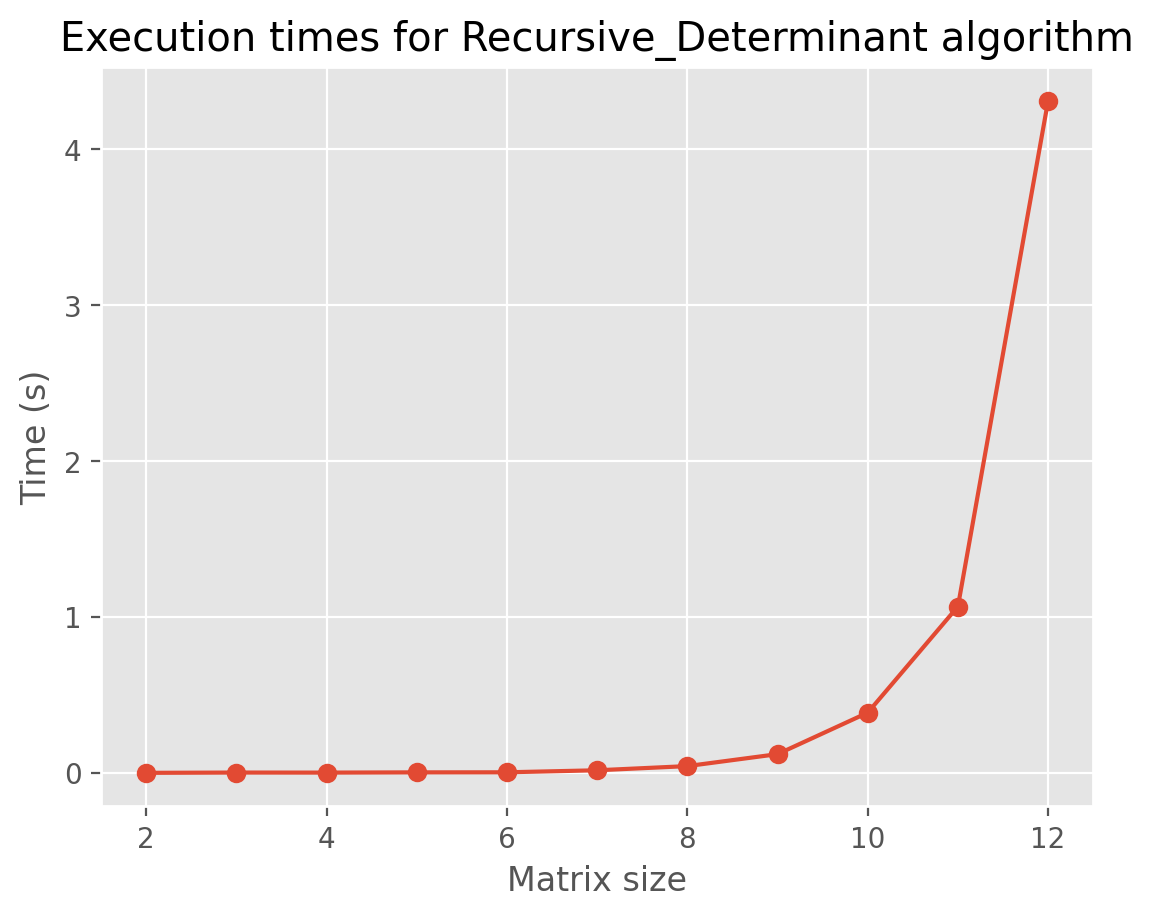

In [35]:
plot_execution_times(recursive_determinant, test_matrices)

#### Liczba operacji zmiennoprzecinkowych

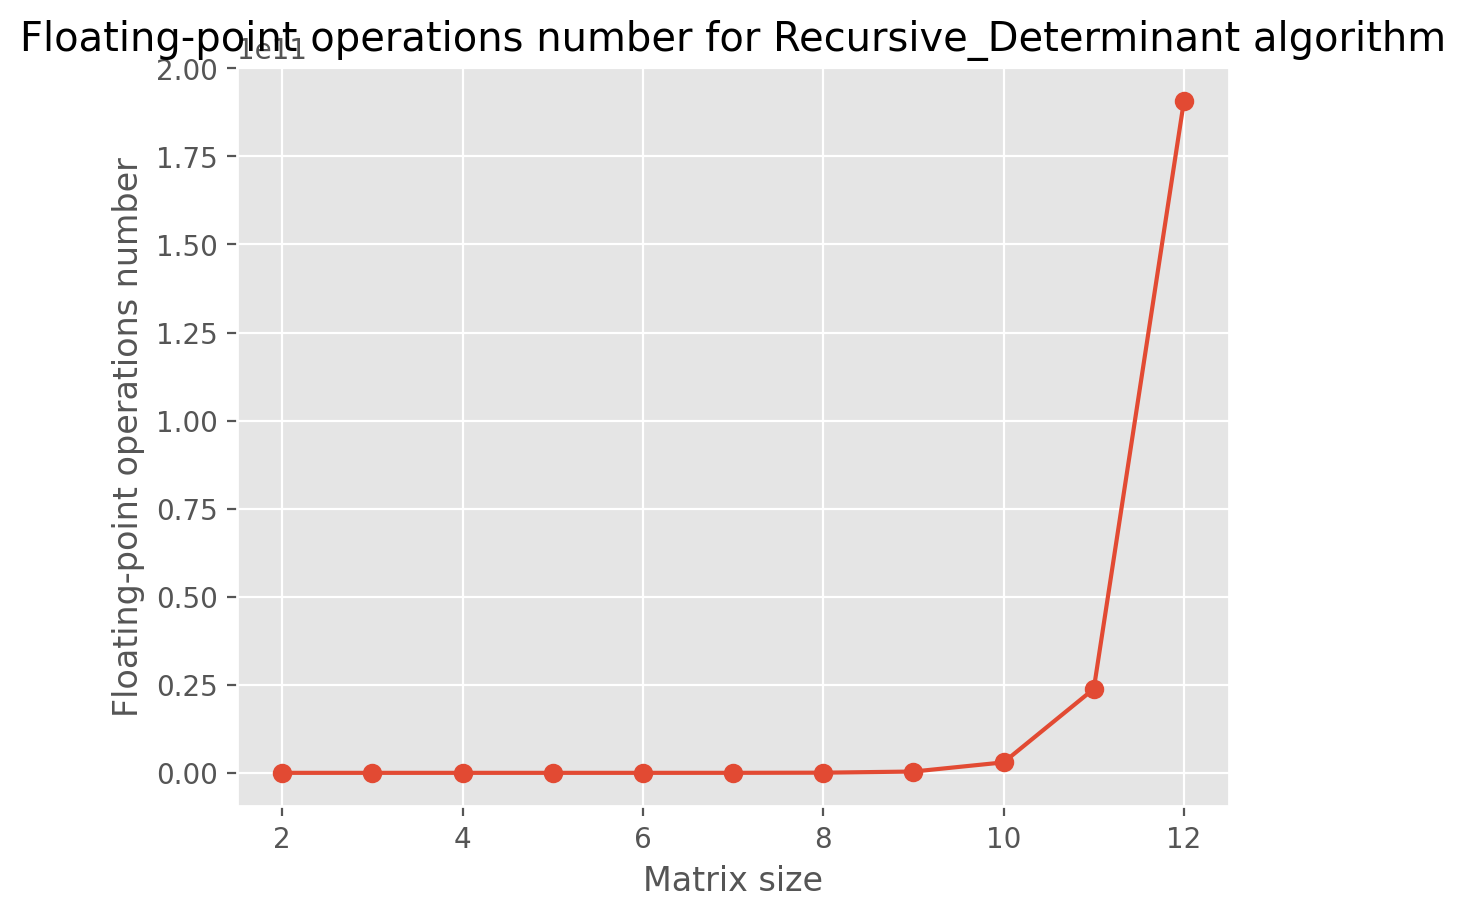

In [36]:
plot_flops(recursive_determinant, test_matrices)

## Porównanie wyników zaimplementowanych algorytmów do mnożenia macierzy w środowisku MATLAB 

## Wnioski